## 1. 문제 정의
- 퇴직금으로 주식 투자를 하려고 함
- 한 종목에 투자하는 것보다는 유망한 주식 200개의 실적에 투자하는 인덱스 펀드가 투자 성향에 맞다고 판단됨
- 지금까지 펀드 시세가 변동된 추이를 학습해 앞으로의 시세를 예측해 보고 싶음

## 2. 오픈소스 기계학습 도구, 프로핏
- 프로핏(Prophet) : 메타(전 페이스북)에서 공개한 시계열에 특화된 예측 라이브러리
- 자동으로 데이터를 학습할 수 있는 오픈소스 기계학습 도구
- sklearn model API를 따름
- 이전의 주가 데이터를 넣고, 이후의 주가 데이터 찾기
- 지금까지의 인구수를 넣고 미래 인구수 예측
- 우리나라 연도별 도시면적을 통해 앞으로의 도시면적 전망

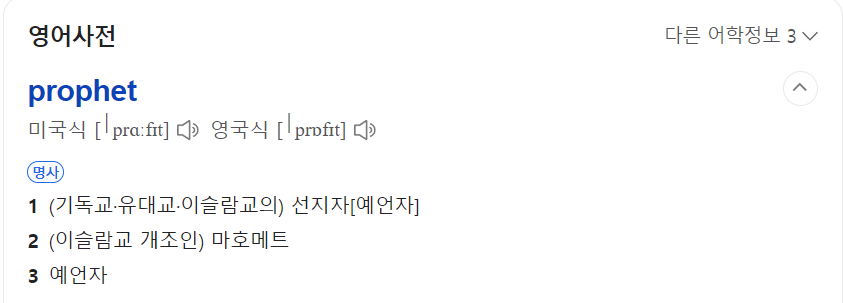

## 3. 프로핏 설치


1. 아나콘다 프롬프트(Anaconda Prompt)창을 관리자 권한으로 열기
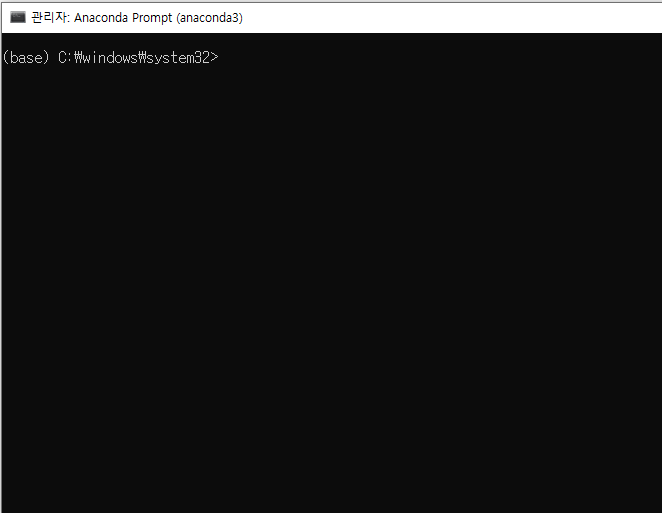
>

2. 아나콘다 프롬프트(Anaconda Prompt)창에서 프로핏 설치
> conda install -c conda-forge prophet
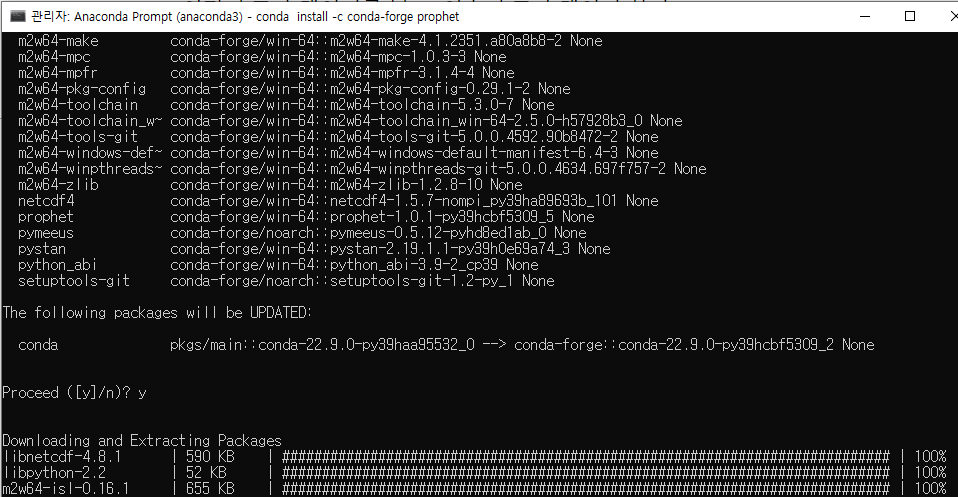
>

3. 프로핏 설치 확인
> conda list
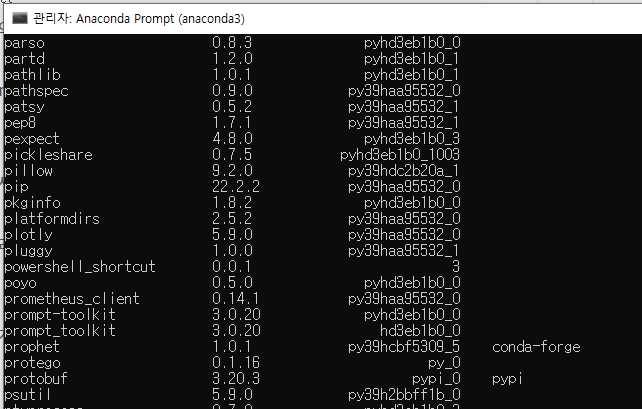

In [ ]:
# prophet 패키지 탑재
from prophet import Prophet

## 4. 주식 시세 데이터 확보하기
### 4.1 "KODEX 200선물인버스2X" 종목 주식 시세 수집
- 네이버 금융 (https://finance.naver.com/) 웹 사이트에서 TOP 종목 중 KODEX 200선물인버스2X 선택
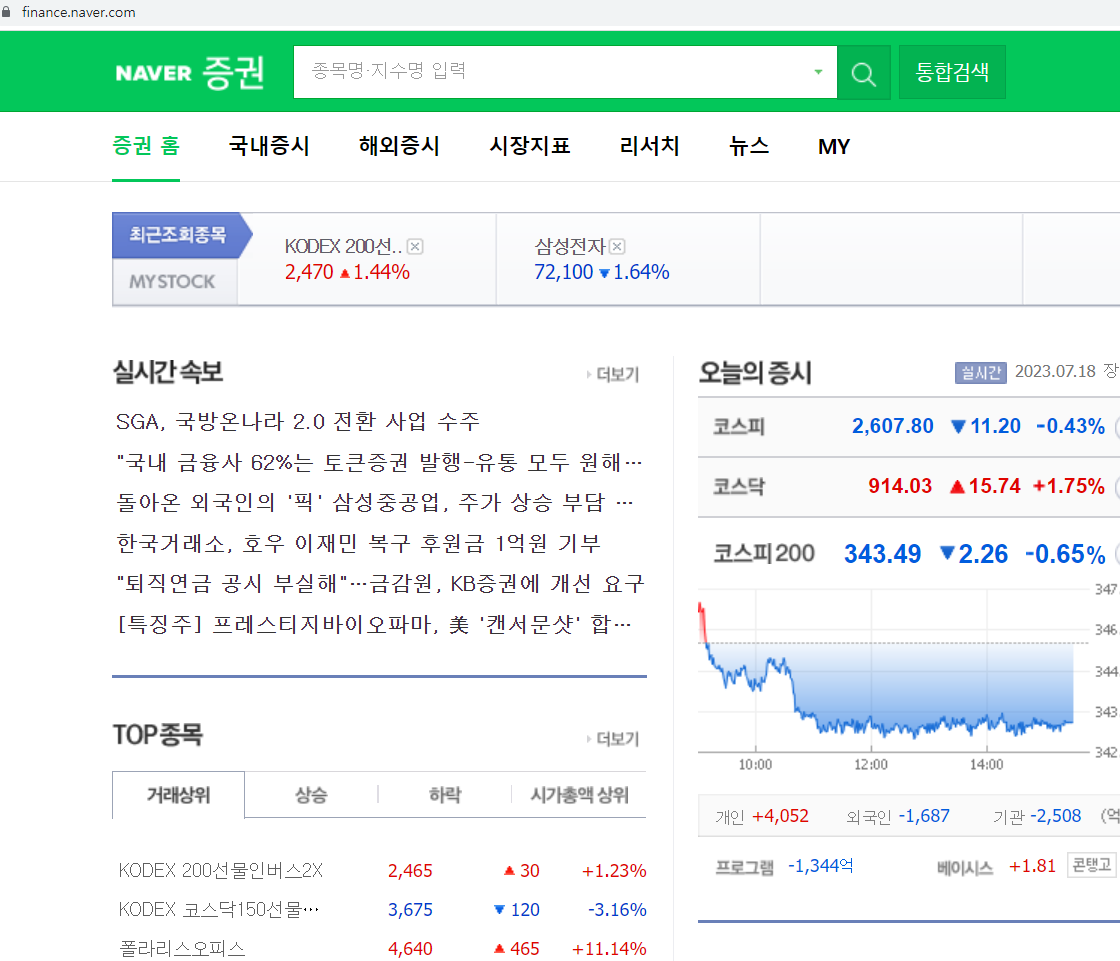


- KODEX 200선물인버스2X 일별시세 (페이지 2를 누르고, [검사]-[Network]-)
- https://finance.naver.com/item/sise_day.naver?code=252670&page=2 확인
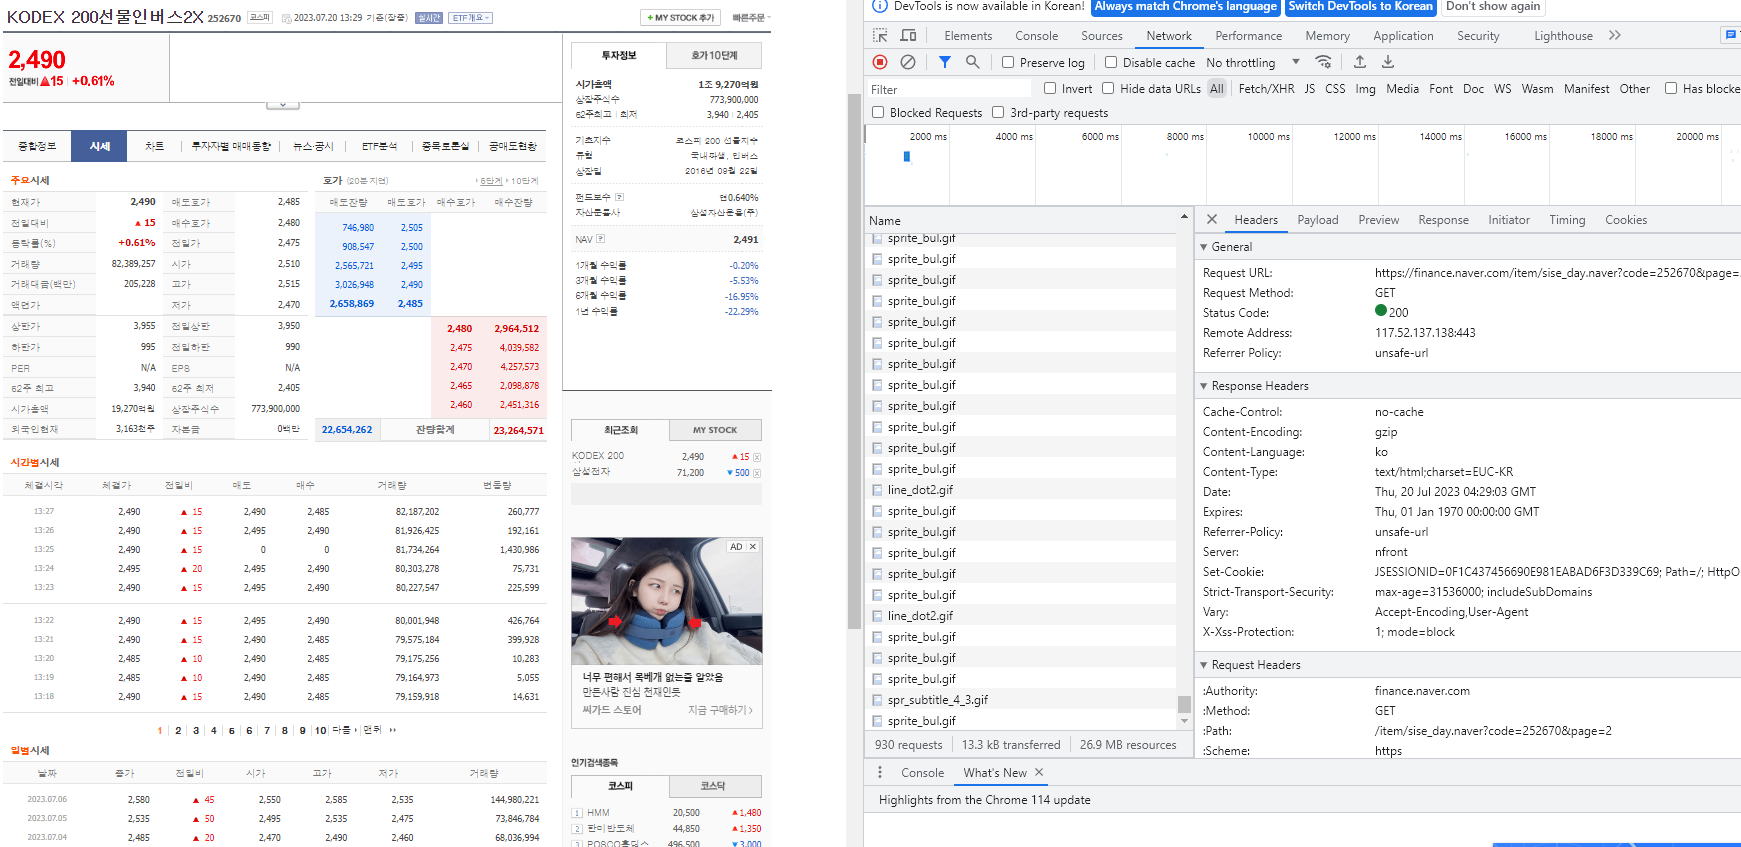

In [ ]:
import pandas as pd
import requests

# 페이지 번호를 제외한 주소 저장
new_url = 'https://finance.naver.com/item/sise_day.naver?code=252670&page='

# 헤더 정보 설정하기
my_headers = {'user-agent' : 'Mozilla/5.0'}

In [ ]:
# 데이터를 축적할 데이터프레임 생성
all_tables_year = pd.DataFrame()

for page_number in range(1, 100):
    
    # 페이지 번호를 추가한 주고 완성
    full_url = new_url + str(page_number)
    
    # 주소 확인하기
    print(f'{page_number}번째 페이지 읽어오기({full_url})')
    
    # HTTP 전송 후 응답 받아오기
    page = requests.get(full_url, headers=my_headers)
    
    # 테이블 추출
    table = pd.read_html(page.text)[0]
    
    # 수행 내용 확인
    print(f'전체{len(all_tables_year.index)}줄에 {len(table.index)}줄 추가')
          
    # 데이터 축적용 데이터프레임에 테이블 추가
    all_tables_year = pd.concat([all_tables_year, table])

### prophet 활용을 위해  주식데이터 가공하기

1. prophet  공식사이트 : https://facebook.github.io/prophet/docs/quick_start.html
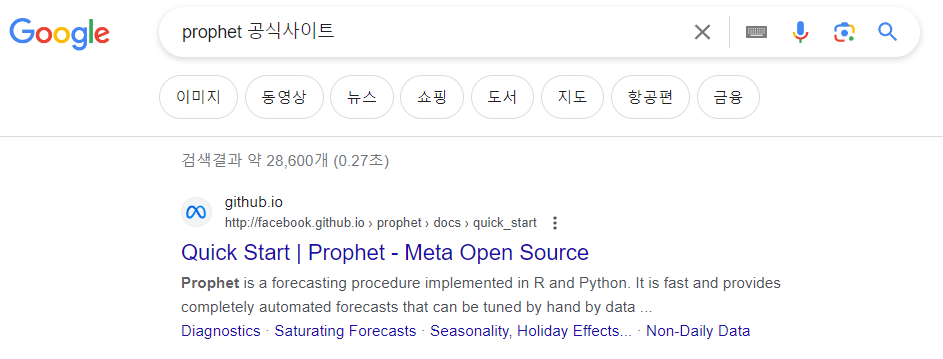

2. The input to Prophet is always a dataframe with two columns: ds and y. 
- Prophet은 sklearn 모델 API를 사용함
> Prophet 인스턴스를 생성한 후, fit과 predict 메서드를 호출하여 실행
- Prophet인스턴스 입력 데이터프레임은 반드시 두 개의 컬럼(변수)을 가지고 잇어야 함 
> ds (DateStamp column) : YYYY-MM-DD 또는 YYYY-MM-DD HH:MM:SS 형태의 시간 <br>
> y : 예측하려는 측정 값 (숫자 유형이어야 함)

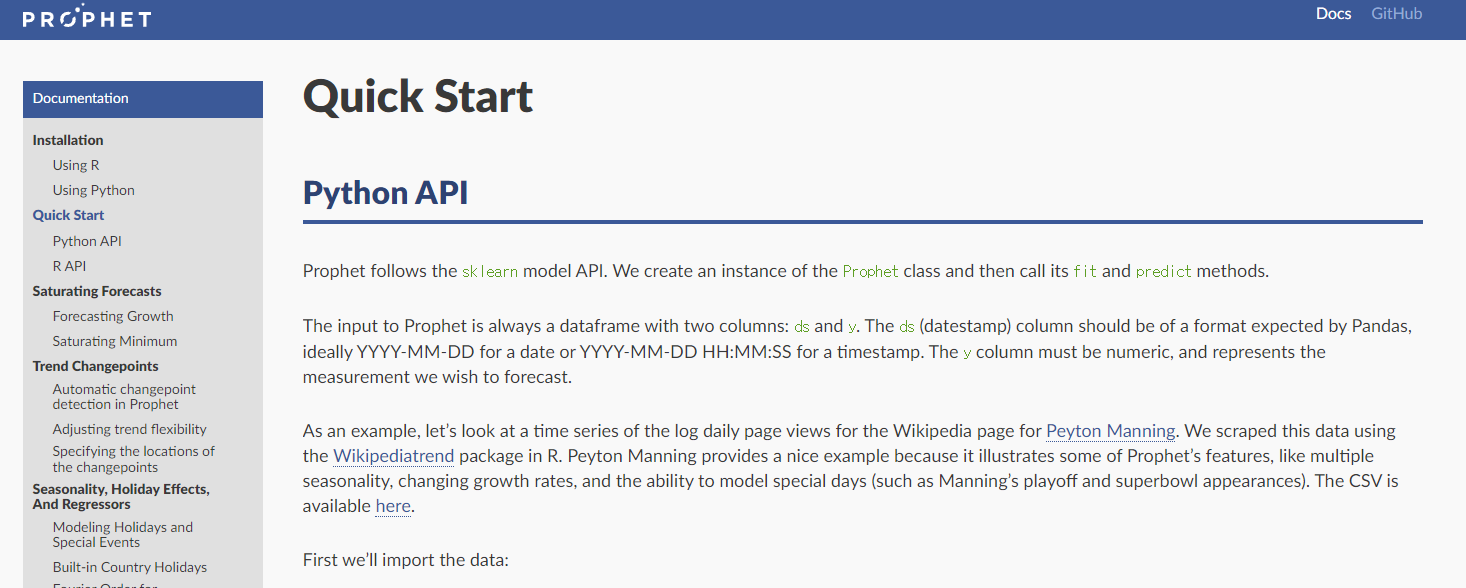

In [ ]:
# 주식 시세 데이터 가공하기
all_tables_year.head()

In [ ]:
# 결손치 제거
all_tables_year.dropna(inplace=True)


### Prophet 패키지를 사용하기 위해 ds(시간)와 y(예측하려는 측정 숫자 값) 변수(컬럼)을 만듬
> ds (DateStamp column) : YYYY-MM-DD 또는 YYYY-MM-DD HH:MM:SS 형태의 시간 <br>
> y : 예측하려는 측정 값 (숫자 유형이어야 함)

In [ ]:
# prophet을 사용하기 위해, 시간 데이터인 변수 '날짜' 이름을 'ds'로 변경
all_tables_year.rename(columns={'날짜' : 'ds'}, inplace=True)

# prophet을 사용하기 위해, 중위값 변수(컬럼) y를 추가
# prophet을 사용하여 중위 값을 예측하려고 함
all_tables_year['y'] = all_tables_year['고가'] - ((all_tables_year['고가'] - all_tables_year['저가'])/2)

# 변수 ds와 y가 추가되었는지 확인
all_tables_year

### 최종입력 데이터프레임 준비하기

In [ ]:
# 학습 대상 데이터프레임 생성
df = pd.DataFrame()

# 필요한 변수(컬럼) ds와 y만 추출하여 저장
df = all_tables_year[['ds', 'y']]

# 데이터프레임 정보 확인하기
# 현재 데이터프레임에는 990개의 데이터가 저장되어 있음을 확인
df.info()

In [ ]:
df

## 5. 데이터 학습 및 시각화

## 5.1 데이터 학습하기

In [ ]:
# 프로핏 모델 객체 인스턴스 만들기
#m = Prophet()
m = Prophet(yearly_seasonality=True, daily_seasonality=True)

# 훈련 데이터(데이터프레임)로 학습(피팅)하여 prophet 모델 만들기
m.fit(df)

In [ ]:
# 예측결과를 저장할 데이터프레임 준비하기
# 여기서는 앞으로 100일(또는 주, 월 등 단위 주기)을 예측하고, 예측 데이터를 담을 데이터프레임(ds 컬럼만 존재) 준비
future = m.make_future_dataframe(periods=100)

In [ ]:
# future 데이터프레임에는 1,090개(기존 990개의 데이터 + 예측 데이터 1,000개)의 데이터를 저장할 데이터프레임(ds 컬럼만 존재) 준비
# 현재는 ds 컬럼만 존재함에 유의하세요
future.info()

In [ ]:
# 데이터프레임 확인
# 예측 데이터 값이 출력
future.tail()

In [ ]:
# 데이터프레임 확인
# 기존 데이터 값을 저장할 날짜 컬럼만 있는 데이터프레임
future.head()

## 5.2 1차 예측 및 시각화

In [ ]:
#  prodict() 함수를 활용하여 1000일치의 데이터를 예측하기
forecast = m.predict(future)

In [ ]:
# 단순 그래프로 시각화 하기
# 파란색 선은 모델이 예측한 값이고, 검정색 점은 실제 데이터임
# 학습한 데이터의 변동폭이 커서, 예측값의 최대, 최소 값 범위가 크다.
fig1 = m.plot(forecast)

In [ ]:
# 예측한 값은 forecast 데이터프레임으로 반환됨
# - ds : 예측한 날짜/시간을 나타내는 컬럼
# - yhat : 모델이 예측한 값이 들어있는 컬럼
# - yhat_lower, yhat_upper: 예측 값의 신뢰 구간을 나타내는 하한과 상한 값이 들어있는 컬럼
# - trend : 전체 시계열의 추세를 나타내는 컬럼
# - weekly : 주 단위 추세를 나타내는 컬럼
forecast.info()

In [ ]:
# 예측결과 앞 부분 확인하기
# yhat : 예측값
# yhat_lower : 예측 최솟 값
# yhat_upper : 예측 최댓 값
forecast.head()

In [ ]:
# 예측결과 끝부분 확인하기
# yhat : 예측값
# yhat_lower : 예측 최솟 값
# yhat_upper : 예측 최댓 값
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# 예측 컴포넌트 확인하기
# 1번 그래프 : 학습한 데이터와 예측한 데이터의 전반적 흐름을 보여줌
# 2번 그래프 : 학습한 데이터의 주 단위 데이터 흐름을 보여줌
# 3번 그래프 : 학습한 데이터의 월 단위 데이터 흐름을 보여줌. 3월에 가장 높고, 2월에 가장 낮음
fig2 = m.plot_components(forecast)

## 5.3 2차 예측 및 시각화
- 데이터 범위 좁히기 (변동폭을 좁히기 위해 2021년 이후 데이터로 범위를 좁힘)

In [ ]:
# 2차 예측을 위한 프로핏 객체 만듬
m2 = Prophet()

# 20221년 이후 데이터만 준비
df2 = df.query('ds > "2021-01-01"')

# 데이터 끝 부분 확인
df2.tail()

In [ ]:
# 재 예측하기
m2.fit(df2)

# 예측 데이터프레임 만들기
future2 = m2.make_future_dataframe(periods=100)

# 예측하기
forecast2 = m2.predict(future2)

# 예측 결과 끝부분 학인하기
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 시각화 하기
fig3 = m2.plot(forecast2)

In [ ]:
# 예측 컴포넌트 확인하기
# 1번 그래프 : 학습한 데이터와 예측한 데이터의 전반적 흐름을 보여줌
# 2번 그래프 : 학습한 데이터의 주 단위 데이터 흐름을 보여줌, 평일에 180 정도오 유지하다가 주말에 -400이상 하락하는 양상
# 3번 그래프 : 학습한 데이터의 월 단위 데이터 흐름을 보여줌. 3월에 가장 높고, 2월에 가장 낮음
fig4 = m2.plot_components(forecast2)

### 대화형 그래프
- 기간을 변경하면서 특정 구간을 자세히 보고싶을 때
- plotly 모듈 사용 (Prophet 설치시 자동 설치됨)
- 아나콘다 프롬프트에서 prophet 설치해야 설치됨

In [ ]:
# plot 모듈 탑재
from prophet.plot import plot_plotly, plot_components_plotly

import plotly.offline as pyo
# Plotly 그래프를 인라인으로 표시
pyo.init_notebook_mode(connected=True)

# 대화형 예측 그래프 그리기
plot_plotly(m2, forecast2)

In [ ]:
# 대화형 예측 컴포넌트 그리기
plot_components_plotly(m, forecast)

## 과제 1
- 학생이 관심있는 종목의 향후 1년 시세를 예측해 보자
- 1년 후, 예측 최댓값과 최솟값이 얼마인지 나열하고, 투자 유무를 결정하는 분석 결과를 도줄해 보자

## 과제 2
- streamlit을 이용하여 웹으로 배포해 보자